In [1]:
import sys
sys.path.append('src')
import argparse
import os
import sys
from typing import List

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
from datasets import Dataset as HFDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)


from bm25_v2 import BM25Searcher
from eval import ModelEvaluator, SearchEvaluator
from utils import (
    AggregatedSearchResult,
    get_combined_df,
    prepare_triplet_data_from_df,
    sanity_check_triplets,
    set_seed,
    tokenize,
    get_recent_df
)
from BERTReranker_v4 import BERTReranker
from CodeReranker import BERTCodeReranker
# set seed
set_seed(42)

/home/ssg2/miniconda3/envs/ds/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# print torch devices available
print('Available devices: ', torch.cuda.device_count())
print('Current cuda device: ', torch.cuda.current_device())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

Available devices:  1
Current cuda device:  0
NVIDIA GeForce RTX 2080 Ti


In [3]:
class Args:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

args = Args(
    index_path='2_8/angular_angular/index_commit_tokenized', repo_path='2_8/angular_angular', k=1000, n=100, no_bm25=True, model_path='microsoft/codebert-base', overwrite_cache=False, batch_size=32, num_epochs=10, learning_rate=5e-05, num_positives=10, num_negatives=10, train_depth=1000, num_workers=8, train_commits=1000, psg_cnt=5, aggregation_strategy='sump', use_gpu=True, rerank_depth=250, do_train=True, do_eval=True, eval_gold=True, openai_model='gpt4', overwrite_eval=False, sanity_check_triplets=False, debug=False, eval_before_training=False, do_combined_train=False, repo_paths=None, best_model_path=None
)

In [32]:
bm25_searcher = BM25Searcher(index_path)

Loaded index at 2_8/angular_angular/index_commit_tokenized
Index Stats: {'total_terms': 12018164, 'documents': 151904, 'non_empty_documents': 151904, 'unique_terms': 15933}


In [34]:
# print bm25 params
print('BM25 params:')
bm25_searcher.searcher.print_bm25_params()

BM25 params:


AttributeError: 'LuceneSearcher' object has no attribute 'print_bm25_params'

In [6]:
metrics = ['MAP', 'P@10', 'P@100', 'P@1000', 'MRR', 'Recall@100', 'Rbecall@1000']
repo_path = args.repo_path
repo_name = repo_path.split('/')[-1]
index_path = args.index_path
K = args.k
n = args.n
combined_df = get_combined_df(repo_path)
BM25_AGGR_STRAT = 'sump'
eval_path = os.path.join(repo_path, 'eval')
if not os.path.exists(eval_path):
    os.makedirs(eval_path)

In [ ]:
repo_name

In [7]:
# find the average number of words in commit_message column
avg_words = combined_df['commit_message'].apply(lambda x: len(x.split())).mean()
print(f'Average number of words in commit_message column: {avg_words}')

Average number of words in commit_message column: 41.4486451969665


In [4]:
tokenizer = AutoTokenizer.from_pretrained(args.model_path)

# find average number of tokens in commit_message column
avg_tokens = combined_df['commit_message'].apply(lambda x: len(tokenizer(x)['input_ids'])).mean()
print(f'Average number of tokens in commit_message column: {avg_tokens}')

NameError: name 'combined_df' is not defined

In [15]:
code_df = pd.read_parquet('2_8/angular_angular/cache/code_data.parquet')

In [20]:
code_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5988 entries, 0 to 5987
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   commit_id  5988 non-null   object
 1   file_path  5988 non-null   object
 2   query      5988 non-null   object
 3   passage    5988 non-null   object
 4   label      5988 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 234.0+ KB


In [18]:
# print first row
print(code_df.iloc[0])

commit_id             8f12f4749262d113accd1a4a82cbbf603e325ce2
file_path    packages/compiler-cli/src/ngtsc/annotations/sr...
query        Invalid hostDirective causes the compiler to c...
passage      /**\n * @license\n * Copyright Google LLC All ...
label                                                        0
Name: 0, dtype: object


In [19]:
# print average number of tokens in query column
avg_tokens = code_df['query'].apply(lambda x: len(tokenizer(x)['input_ids'])).mean()
print(f'Average number of tokens in query column: {avg_tokens}')

Average number of tokens in query column: 36.710420841683366


In [8]:
import pickle

In [14]:
REPO_PATHS = ['2_7/facebook_react', '2_8/angular_angular', '2_7/apache_spark', '2_7/apache_kafka', '2_8/django_django', '2_7/julialang_julia', '2_7/ruby_ruby', '2_8/pytorch_pytorch', '2_9/huggingface_transformers', '2_9/redis_redis']
# REPO_PATHS = ['2_7/facebook_react']
print(len(REPO_PATHS))

10


In [25]:
triplets = pickle.load(open('2_8/angular_angular/cache/gpt_triplet_data_cache.pkl', 'rb'))

In [27]:
triplets.info()
# print label distribution
print(triplets['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6894 entries, 0 to 6893
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   query    6894 non-null   object
 1   passage  6894 non-null   object
 2   label    6894 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 161.7+ KB
label
0    4962
1    1932
Name: count, dtype: int64


In [31]:
# iterate over all repos and find the average label distribution from their triplet data file located at (repo_path)/cache/gpt_triplet_data_cache.pkl

label_counts = []
for repo_path in REPO_PATHS:
    # triplets = pickle.load(open(os.path.join(repo_path, 'cache/triplet_data_cache.pkl'), 'rb'))
    triplets = pd.read_parquet(os.path.join(repo_path, 'cache/gpt_triplet_data_cache.parquet'))
    label_counts.append(triplets['label'].value_counts())

label_counts_df = pd.concat(label_counts, axis=1)
label_counts_df.columns = REPO_PATHS
label_counts_df = label_counts_df.fillna(0)
label_counts_df['avg'] = label_counts_df.mean(axis=1)
label_counts_df = label_counts_df.astype(int)
label_counts_df

,2_7/facebook_react,2_8/angular_angular,2_7/apache_spark,2_7/apache_kafka,2_8/django_django,2_7/julialang_julia,2_7/ruby_ruby,2_8/pytorch_pytorch,2_9/huggingface_transformers,2_9/redis_redis,avg
label,,,,,,,,,,,
0,204216,98670,114274,117685,118380,119732,121933,106250,111869,120614,123362
1,65876,15341,23584,33298,16385,19243,11952,17943,27150,22905,25367


In [15]:
# print average tokens per repository for query column
avg_tokens_list = []
for repo_path in ['2_7/facebook_react']:
    # triplets = pickle.load(open(os.path.join(repo_path, 'cache/triplet_data_cache.pkl'), 'rb'))
    triplets = pd.read_parquet(os.path.join(repo_path, 'cache/gpt_triplet_data_cache.parquet'))
    # get unique commit_messages
    commit_messages = triplets['query'].unique()

    # calculate average number of tokens in commit_message column
    avg_tokens = np.mean([len(tokenizer(x)['input_ids']) for x in commit_messages])

    avg_tokens_list.append(avg_tokens)

avg_tokens_df = pd.DataFrame({'repo_path': REPO_PATHS, 'avg_tokens': avg_tokens_list})
avg_tokens_df

,repo_path,avg_tokens
0,2_7/facebook_react,231.290000
1,2_8/angular_angular,197.170341
2,2_7/apache_spark,819.947000
3,2_7/apache_kafka,254.962000
4,2_8/django_django,59.925000
5,2_7/julialang_julia,124.384513
6,2_7/ruby_ruby,156.106212
7,2_8/pytorch_pytorch,494.504514
8,2_9/huggingface_transformers,388.608040
9,2_9/redis_redis,236.111670


In [9]:
# get a sample row from the combined df
combined_df.sample(1, random_state=42)['diff'].values[0]

'@@ -195,6 +195,18 @@ function throwException(\n     // This is a thenable.\n     const thenable: Thenable = (value: any);\n \n+    if ((sourceFiber.mode & BlockingMode) === NoMode) {\n+      // Reset the memoizedState to what it was before we attempted\n+      // to render it.\n+      let currentSource = sourceFiber.alternate;\n+      if (currentSource) {\n+        sourceFiber.memoizedState = currentSource.memoizedState;\n+        sourceFiber.expirationTime = currentSource.expirationTime;\n+      } else {\n+        sourceFiber.memoizedState = null;\n+      }\n+    }\n+\n     checkForWrongSuspensePriorityInDEV(sourceFiber);\n \n     let hasInvisibleParentBoundary = hasSuspenseContext(\n'

In [76]:
def plot_stats(combined_df, repo_name):
    # enable index to be used as x-axis
    df = combined_df.groupby('commit_id').size().reset_index(name='num_files')
    df.reset_index(inplace=True)
    avg_num_files = df.num_files.mean()
    median_num_files = df.num_files.median()
    # df.plot.scatter(x='commit_id', y='num_files')
    # sort by number of files
    # df.sort_values(by='num_files', inplace=True, ascending=False)
    plt.scatter(df.index, df.num_files, s=1)
    plt.xlabel('Commit Number')
    plt.ylabel('Number of Files Changed')
    plt.title(f'({repo_name}) - avg (b) {avg_num_files:.2f}, median (g) {median_num_files:.2f} files changed per commit')

    # plot average number of files changed in a commit
    plt.axhline(y=avg_num_files, color='b', linestyle='-')
    plt.axhline(y=median_num_files, color='g', linestyle='--')
    # save in misc/eda folder
    plt.savefig(f'misc/eda/{repo_name}_num_files.png', dpi=300)
    return median_num_files, avg_num_files

def do_eda(combined_df, repo_name):
    num_commits = combined_df.commit_id.nunique()
    total_files_edited = combined_df.shape[0]
    median_num_files, avg_num_files = plot_stats(combined_df, repo_name)
    plot_stats(combined_df, repo_name)

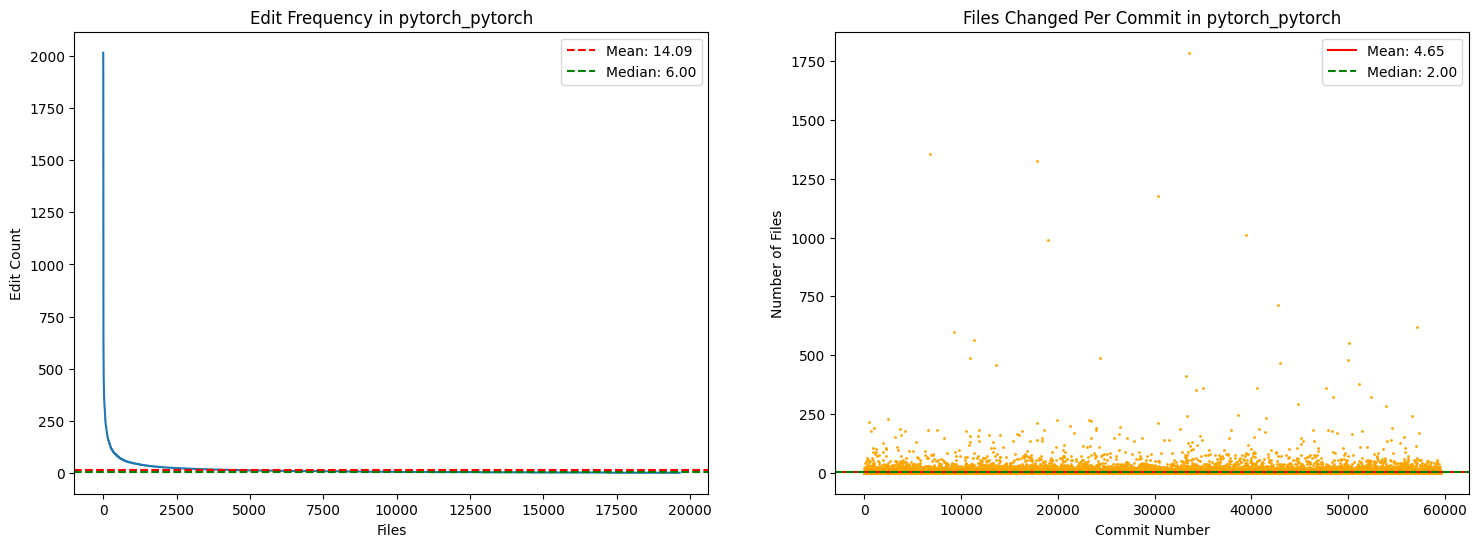

FileNotFoundError: [Errno 2] No such file or directory: 'pytorch_pytorch/cache/code_data.parquet'

In [121]:
repo_path = '2_8/pytorch_pytorch'
repo_name = repo_path.split('/')[-1]
combined_df = get_combined_df(repo_path)
do_eda(combined_df, repo_name)

In [109]:
def plot_combined_stats(combined_df, repo_name):
    # For edit frequency plot
    total_unique_commits = combined_df['commit_id'].nunique()
    file_edit_count = combined_df.groupby('file_path').size().reset_index(name='edit_count')
    file_edit_count = file_edit_count.sort_values(by='edit_count', ascending=False)
    file_edit_count['edit_percentage'] = file_edit_count['edit_count'] / total_unique_commits * 100
    mean_edit_frequency = file_edit_count['edit_count'].mean()
    median_edit_frequency = file_edit_count['edit_count'].median()

    # For number of files changed per commit plot
    df = combined_df.groupby('commit_id').size().reset_index(name='num_files')
    df.reset_index(inplace=True)
    mean_num_files = df.num_files.mean()
    median_num_files = df.num_files.median()

    # Plot 1: Edit Frequency
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(file_edit_count['edit_count'].values)
    plt.axhline(mean_edit_frequency, color='r', linestyle='--', label=f'Mean: {mean_edit_frequency:.2f}')
    plt.axhline(median_edit_frequency, color='g', linestyle='--', label=f'Median: {median_edit_frequency:.2f}')
    plt.title(f'Edit Frequency in {repo_name}')
    plt.xlabel('Files')
    plt.ylabel('Edit Count')
    plt.legend()

    # Plot 2: Number of Files Changed Per Commit
    plt.subplot(1, 2, 2)
    plt.scatter(df.index, df.num_files, s=1, color='orange')
    plt.axhline(y=mean_num_files, color='r', linestyle='-', label=f'Mean: {mean_num_files:.2f}')
    plt.axhline(y=median_num_files, color='g', linestyle='--', label=f'Median: {median_num_files:.2f}')
    plt.title(f'Files Changed Per Commit in {repo_name}')
    plt.xlabel('Commit Number')
    plt.ylabel('Number of Files')
    plt.legend()

    # Save plots
    plt.savefig(f'misc/eda/{repo_name}_combined_stats.png', dpi=300)
    plt.show()

    return mean_edit_frequency, median_edit_frequency, mean_num_files, median_num_files

def do_eda(combined_df, repo_path):
    repo_name = repo_path.split('/')[-1]
    tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
    def tokenize(x):
        # tokenize with no max length
        return tokenizer.encode(x, add_special_tokens=True, truncation=False, max_length=None)
    num_commits = combined_df.commit_id.nunique()
    total_files_edited = combined_df.shape[0]
    mean_edit_frequency, median_edit_frequency, mean_num_files, median_num_files = plot_combined_stats(combined_df, repo_name)

    # round to 1 decimal place
    mean_edit_frequency = round(mean_edit_frequency, 1)
    median_edit_frequency = round(median_edit_frequency, 1)
    mean_num_files = round(mean_num_files, 1)
    median_num_files = round(median_num_files, 1)

    code_data = os.path.join(repo_path, 'cache', 'code_data.parquet')
    sample_df = pd.read_parquet(code_data)
    print(sample_df.info())
    avg_words = round(sample_df['query'].apply(lambda x: len(tokenize(x))).mean(),1)
    print(f'Average number of tokens in query: {avg_words}')

    avg_path = round(sample_df['file_path'].apply(lambda x: len(tokenize(x))).mean(),1)
    print(f'Average number of tokens in path: {avg_path}')


    # print remaining number of tokens in bert (max is 512)
    avg_remaining_tokens = round(512 - avg_words - avg_path,1)
    print(f'Avg number of tokens remaining for code: {avg_remaining_tokens}')

    # avg_file_tokens = sample_df['passage'].dropna().apply(lambda x: len(tokenize(x))).mean()
    # print(f'Average number of code tokens in cur_file_content column: {avg_file_tokens}')
    return num_commits, total_files_edited, mean_edit_frequency, median_edit_frequency, mean_num_files, median_num_files, avg_words, avg_path, avg_remaining_tokens

Analyzing 2_7/facebook_react


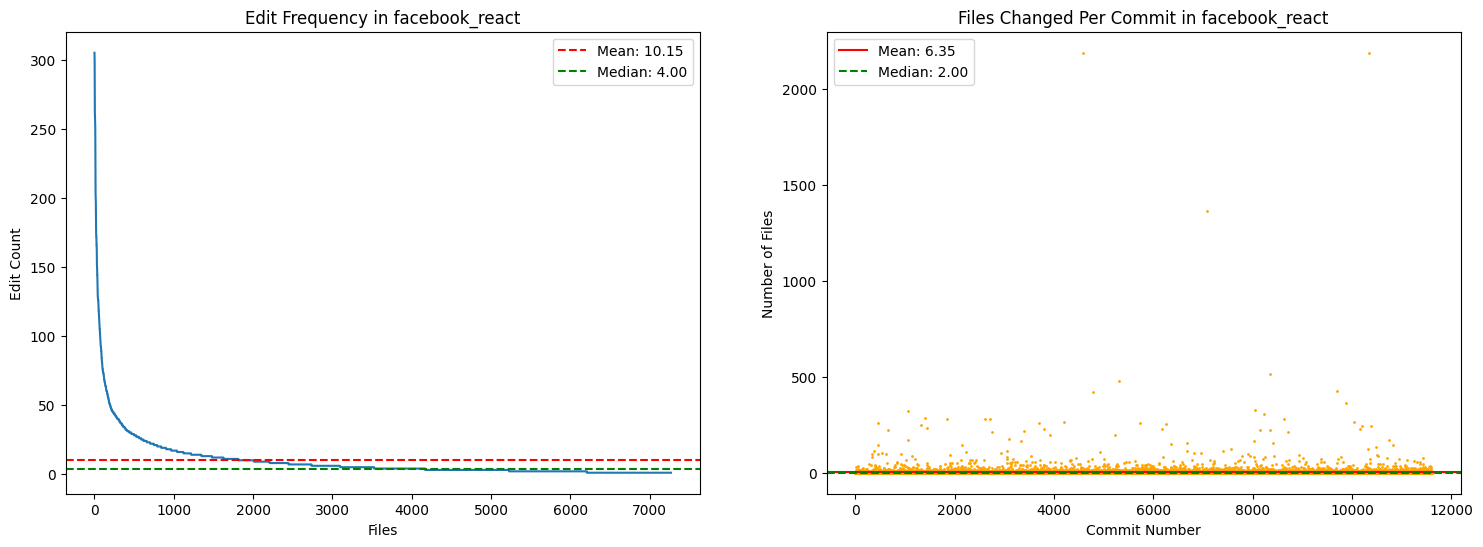

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13942 entries, 0 to 13941
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   commit_id  13942 non-null  object
 1   file_path  13942 non-null  object
 2   query      13942 non-null  object
 3   passage    13942 non-null  object
 4   label      13942 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 544.7+ KB
None


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


Average number of tokens in query: 242.1
Average number of tokens in path: 20.9
Avg number of tokens remaining for code: 249.0
Analyzing 2_8/angular_angular


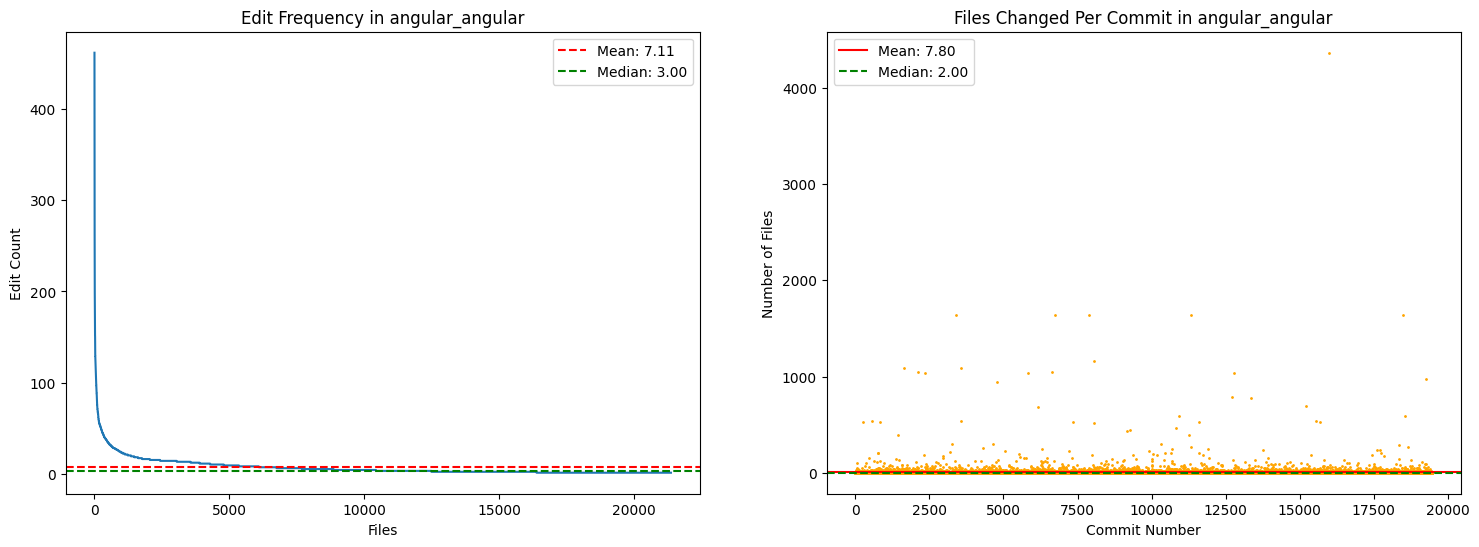

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5988 entries, 0 to 5987
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   commit_id  5988 non-null   object
 1   file_path  5988 non-null   object
 2   query      5988 non-null   object
 3   passage    5988 non-null   object
 4   label      5988 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 234.0+ KB
None
Average number of tokens in query: 36.7
Average number of tokens in path: 20.3
Avg number of tokens remaining for code: 455.0
Analyzing 2_7/apache_spark


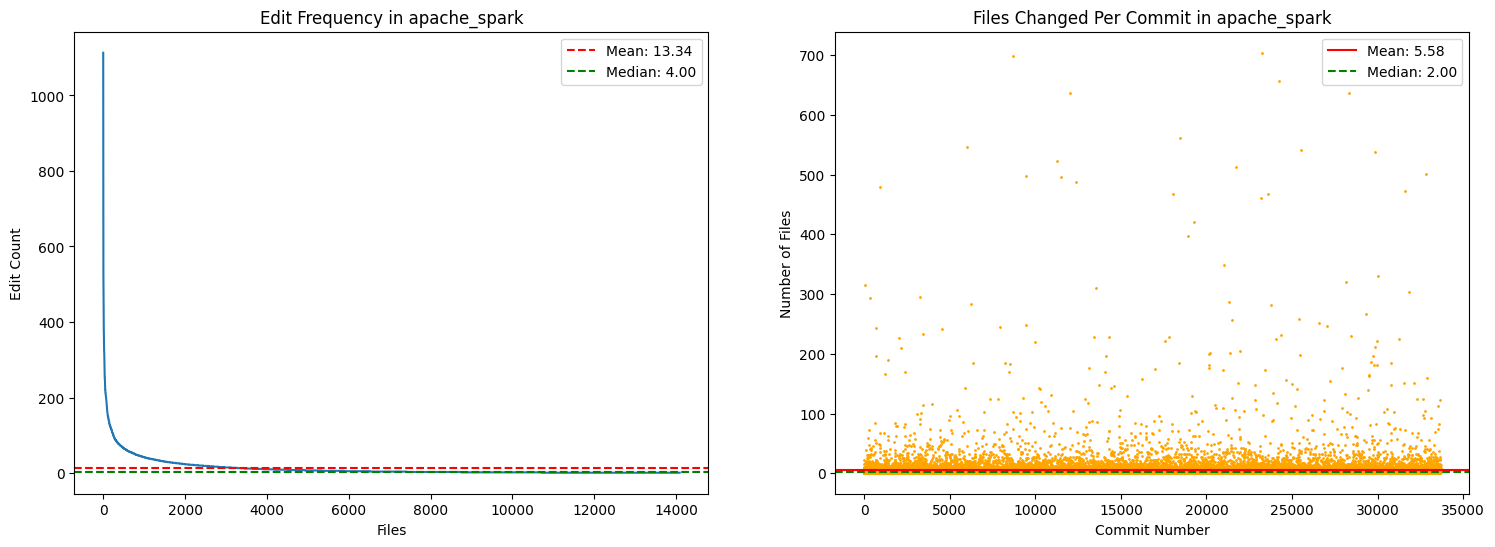

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6233 entries, 0 to 6232
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   commit_id  6233 non-null   object
 1   file_path  6233 non-null   object
 2   query      6233 non-null   object
 3   passage    6233 non-null   object
 4   label      6233 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 243.6+ KB
None
Average number of tokens in query: 39.6
Average number of tokens in path: 30.3
Avg number of tokens remaining for code: 442.1
Analyzing 2_7/apache_kafka


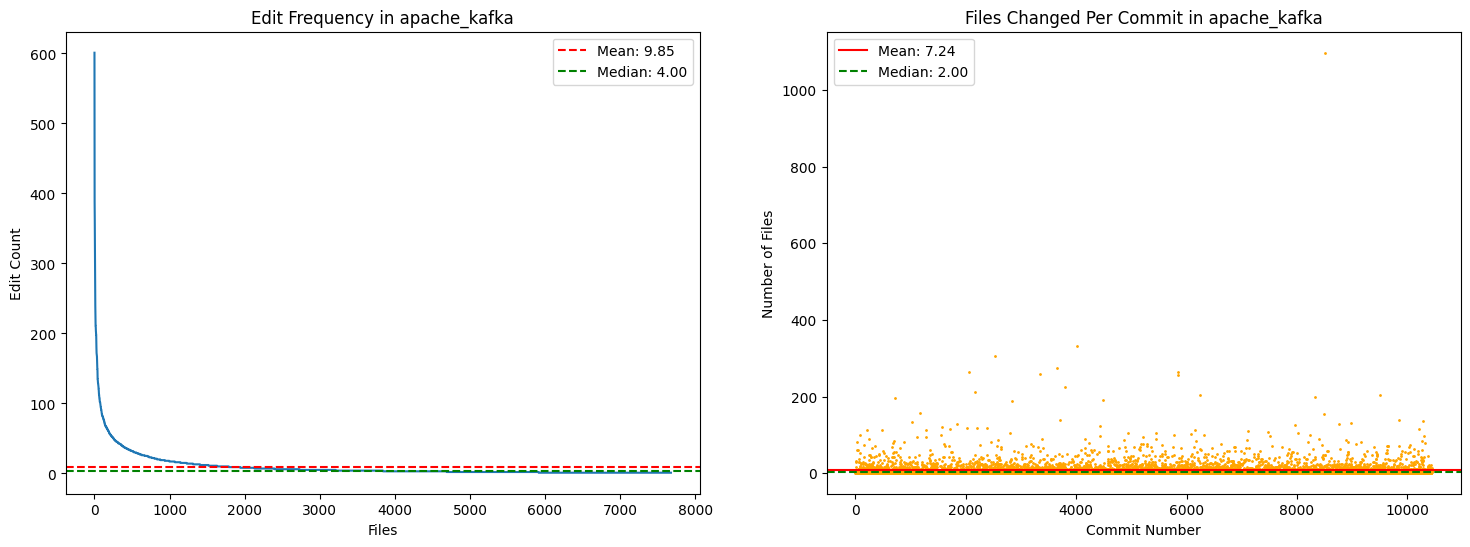

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6624 entries, 0 to 6623
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   commit_id  6624 non-null   object
 1   file_path  6624 non-null   object
 2   query      6624 non-null   object
 3   passage    6624 non-null   object
 4   label      6624 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 258.9+ KB
None
Average number of tokens in query: 37.1
Average number of tokens in path: 28.1
Avg number of tokens remaining for code: 446.8
Analyzing 2_8/django_django


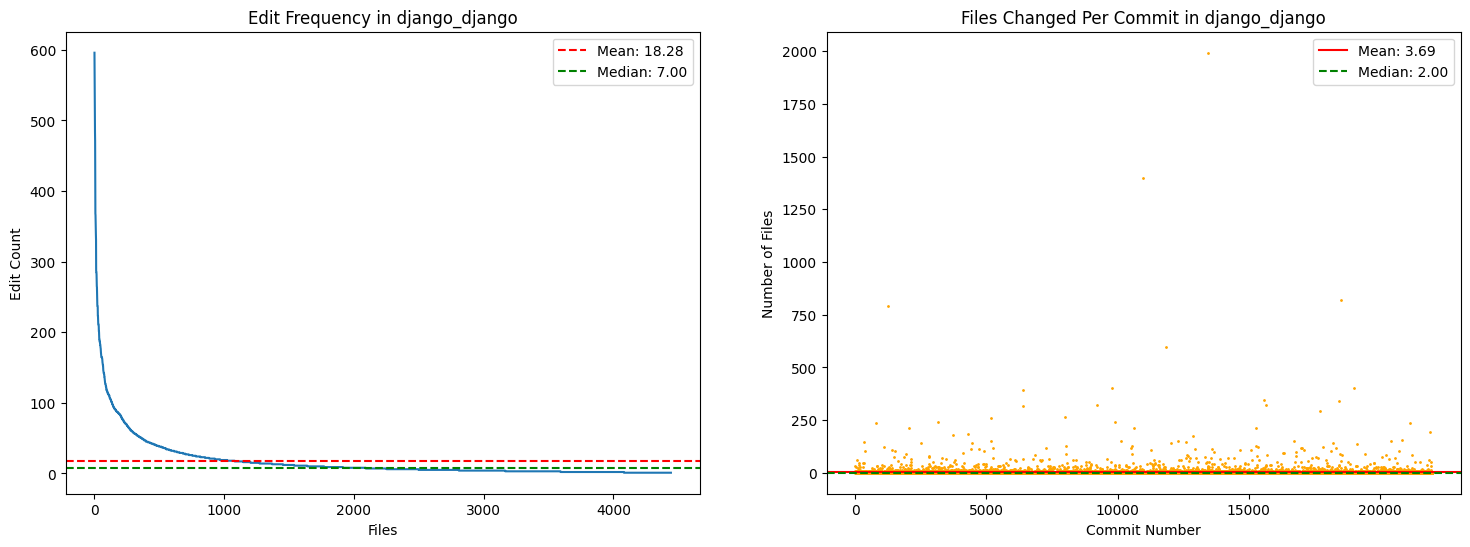

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   commit_id  5808 non-null   object
 1   file_path  5808 non-null   object
 2   query      5808 non-null   object
 3   passage    5808 non-null   object
 4   label      5808 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 227.0+ KB
None
Average number of tokens in query: 27.3
Average number of tokens in path: 14.0
Avg number of tokens remaining for code: 470.7
Analyzing 2_7/julialang_julia


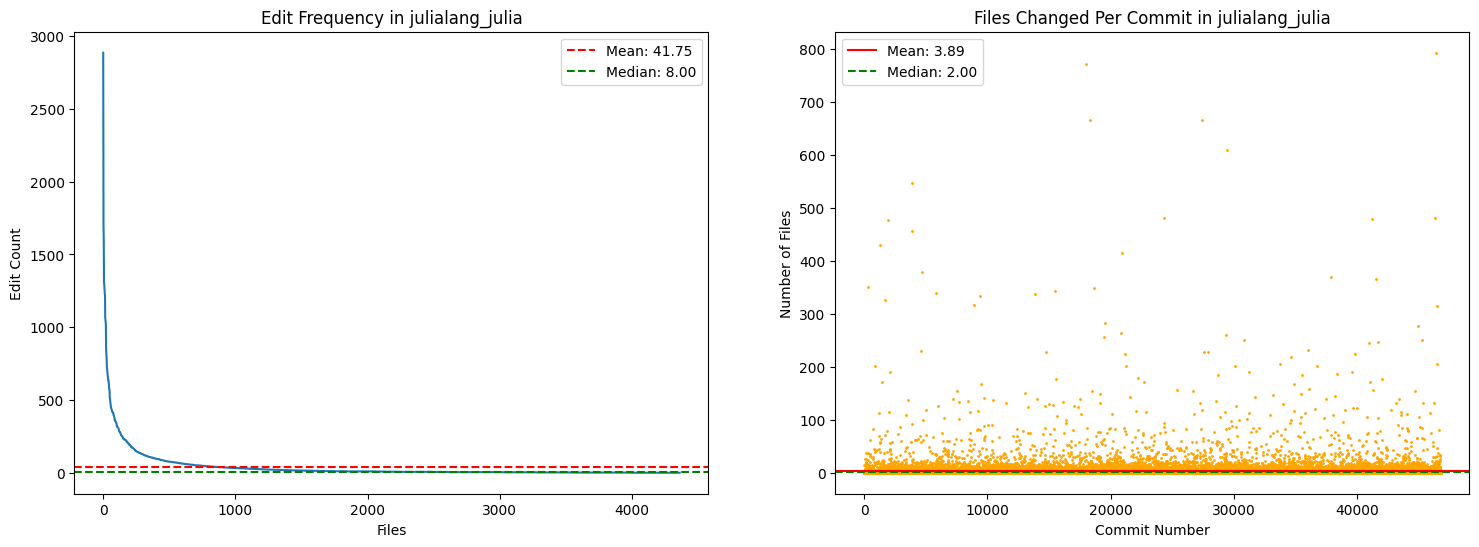

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   commit_id  5856 non-null   object
 1   file_path  5856 non-null   object
 2   query      5856 non-null   object
 3   passage    5856 non-null   object
 4   label      5856 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 228.9+ KB
None
Average number of tokens in query: 32.2
Average number of tokens in path: 9.0
Avg number of tokens remaining for code: 470.8
Analyzing 2_7/ruby_ruby


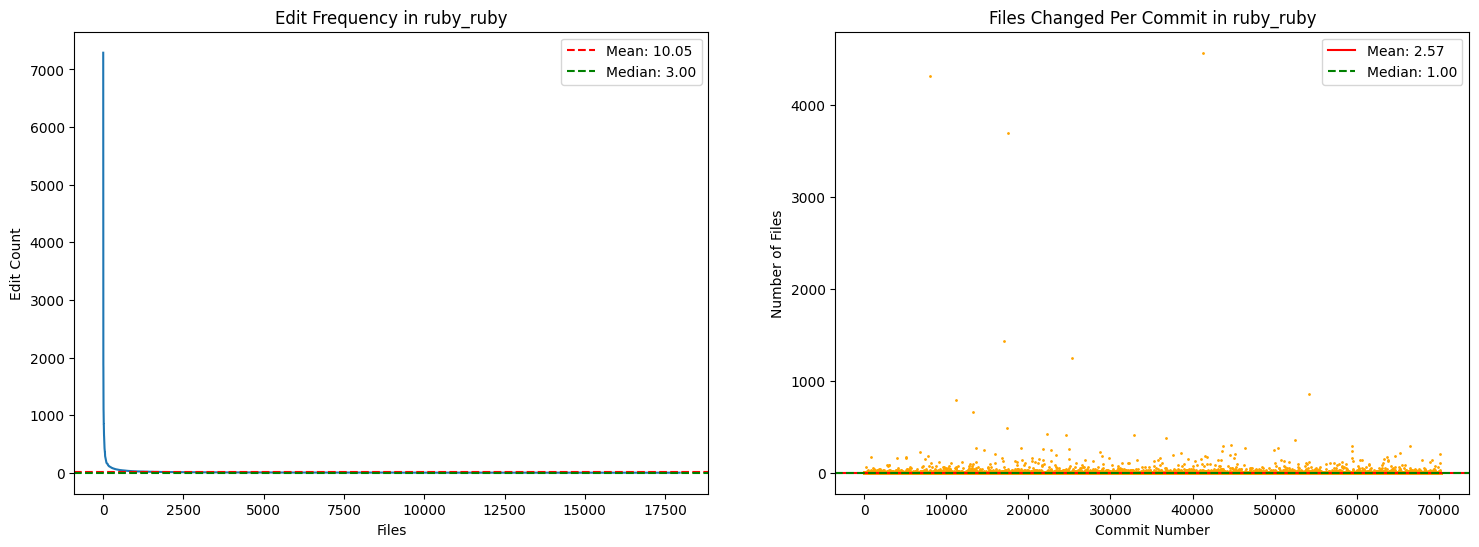

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531 entries, 0 to 5530
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   commit_id  5531 non-null   object
 1   file_path  5531 non-null   object
 2   query      5531 non-null   object
 3   passage    5531 non-null   object
 4   label      5531 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 216.2+ KB
None
Average number of tokens in query: 32.0
Average number of tokens in path: 6.6
Avg number of tokens remaining for code: 473.4
Analyzing 2_8/pytorch_pytorch


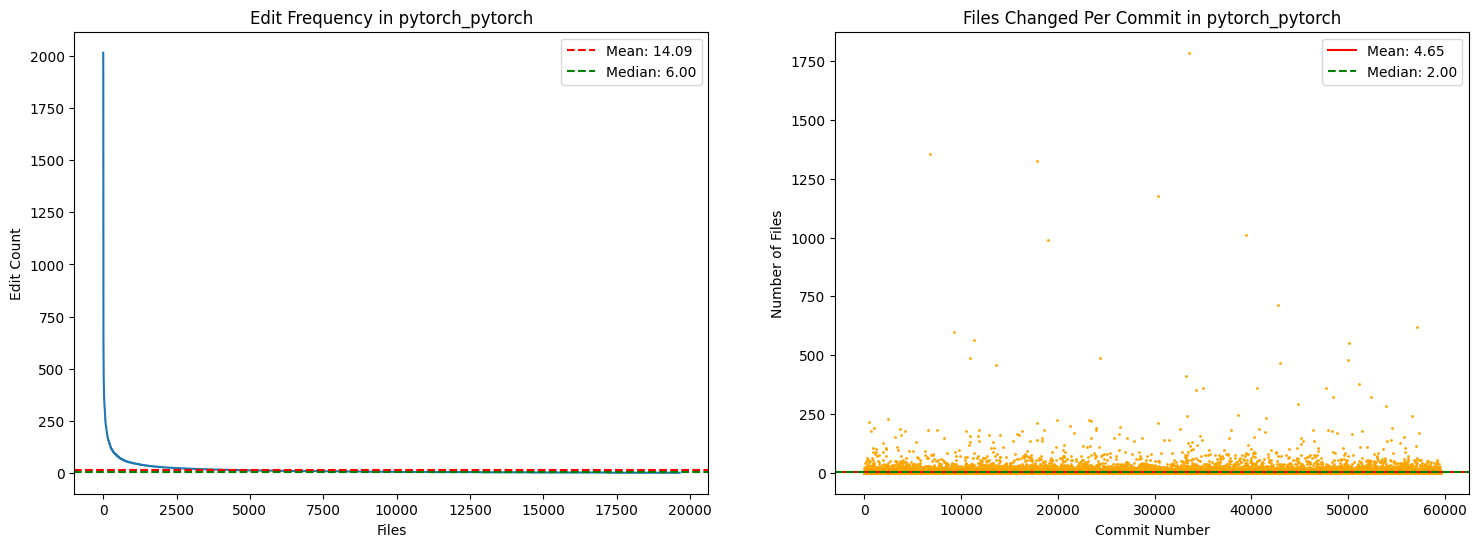

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5883 entries, 0 to 5882
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   commit_id  5883 non-null   object
 1   file_path  5883 non-null   object
 2   query      5883 non-null   object
 3   passage    5883 non-null   object
 4   label      5883 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 229.9+ KB
None
Average number of tokens in query: 38.4
Average number of tokens in path: 14.5
Avg number of tokens remaining for code: 459.1
Analyzing 2_9/huggingface_transformers


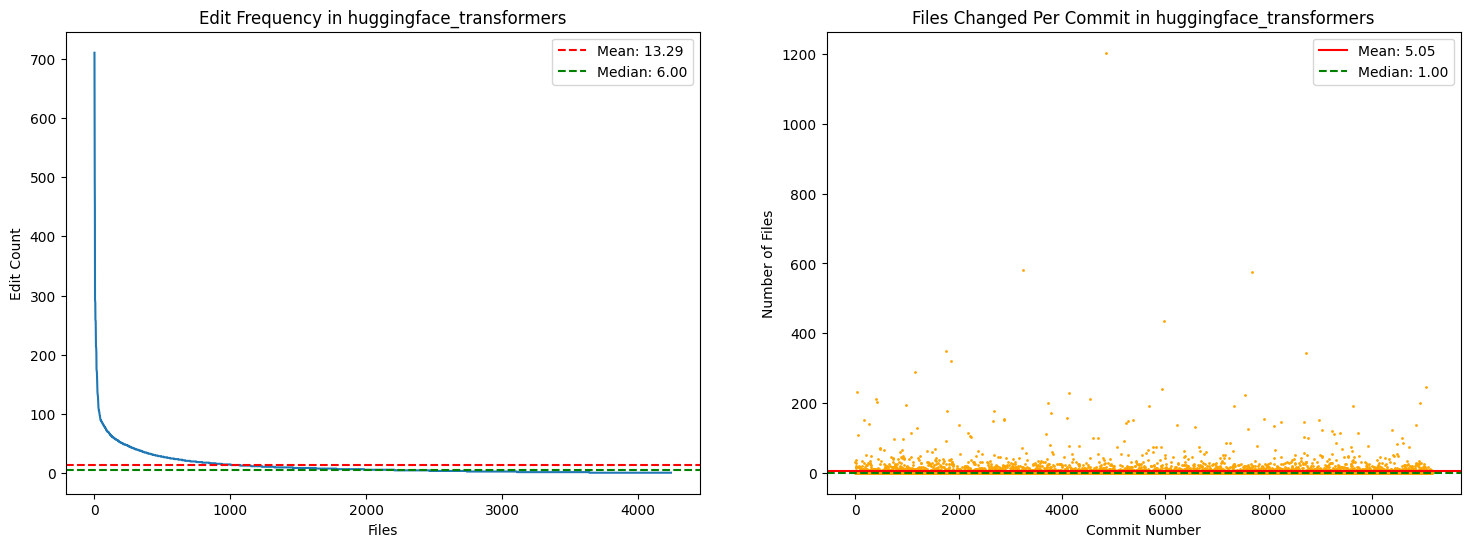

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6433 entries, 0 to 6432
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   commit_id  6433 non-null   object
 1   file_path  6433 non-null   object
 2   query      6433 non-null   object
 3   passage    6433 non-null   object
 4   label      6433 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 251.4+ KB
None
Average number of tokens in query: 33.8
Average number of tokens in path: 15.2
Avg number of tokens remaining for code: 463.0
Analyzing 2_9/redis_redis


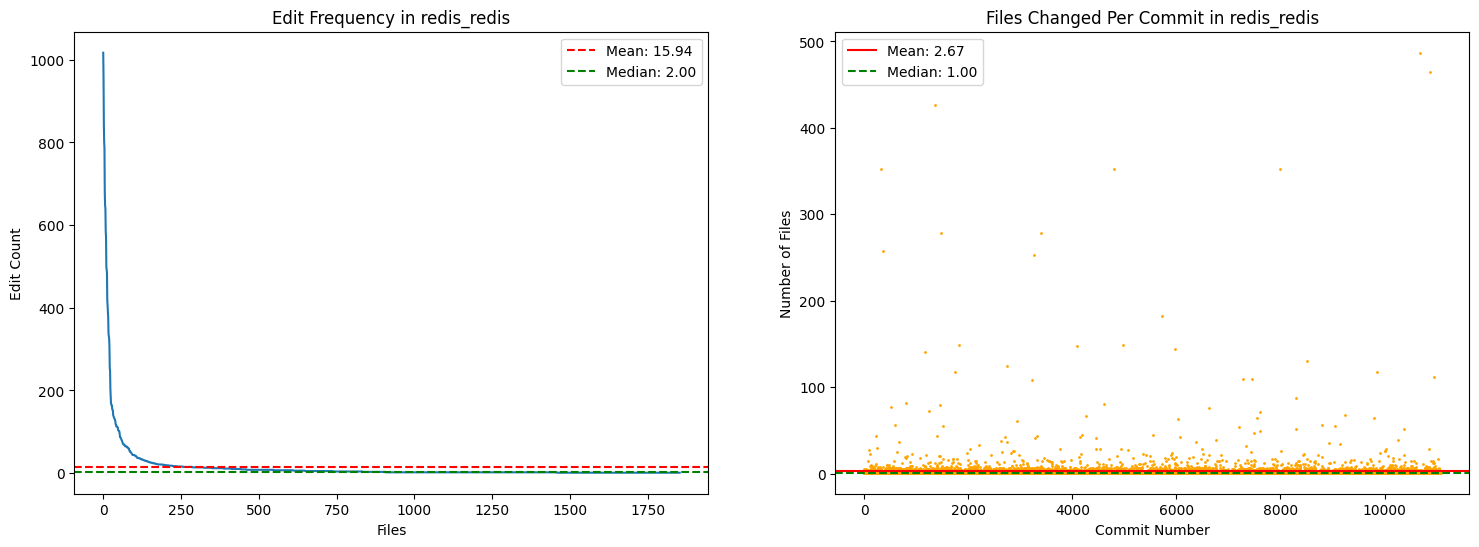

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5951 entries, 0 to 5950
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   commit_id  5951 non-null   object
 1   file_path  5951 non-null   object
 2   query      5951 non-null   object
 3   passage    5951 non-null   object
 4   label      5951 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 232.6+ KB
None
Average number of tokens in query: 37.5
Average number of tokens in path: 8.1
Avg number of tokens remaining for code: 466.4


In [119]:
# open a file called misc/eda_train.txt
# if already exists, delete and create new
if os.path.exists('misc/eda_train.txt'):
    os.remove('misc/eda_train.txt')


eda_train_file = open('misc/eda_train.txt', 'w')

# write header
eda_train_file.write('repo_name,num_commits,total_files_edited,mean_edit_frequency,median_edit_frequency,mean_num_files,median_num_files,avg_commit_message_len,avg_file_path_len,avg_remaining_tokens\n')


for repo_path in REPO_PATHS:
    print(f'Analyzing {repo_path}')
    combined_df = get_combined_df(repo_path)
    num_commits, total_files_edited, mean_edit_frequency, median_edit_frequency, mean_num_files, median_num_files, avg_words, avg_path, avg_remaining_tokens = do_eda(combined_df, repo_path)

    # write to file
    eda_train_file.write(f'{repo_path},{num_commits},{total_files_edited},{mean_edit_frequency},{median_edit_frequency},{mean_num_files},{median_num_files},{avg_words},{avg_path},{avg_remaining_tokens}\n')


eda_train_file.close()

In [113]:
def do_eda_test(repo_name):
    gold_dir = os.path.join('gold', repo_name)
    gold_path = os.path.join(gold_dir, f'v2_{repo_name}_{args.openai_model}_gold.parquet')
    if not os.path.exists(gold_path):
        print(f'Gold file does not exist for {repo_name}')
        return

    tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
    def tokenize(x):
        # tokenize with no max length
        return tokenizer.encode(x, add_special_tokens=True, truncation=False, max_length=None)

    gold_df = pd.read_parquet(gold_path)

    avg_commit_query_len = round(gold_df['commit_message'].apply(lambda x: len(tokenize(x))).mean(),1)
    avg_gpt4_query_len = round(gold_df['transformed_message_gpt4'].apply(lambda x: len(tokenize(x))).mean(),1)

    # find avg_files_edited by averaging the length of lists in the column actual_files_modified
    avg_files_edited = round(gold_df['actual_files_modified'].apply(lambda x: len(x)).mean(),1)
    median_files_edited = round(gold_df['actual_files_modified'].apply(lambda x: len(x)).median(),1)

    return avg_commit_query_len, avg_gpt4_query_len, avg_files_edited, median_files_edited

In [120]:
if os.path.exists('misc/eda_test.txt'):
    os.remove('misc/eda_test.txt')


eda_test_file  = open('misc/eda_test.txt', 'w')

eda_test_file.write('repo_name,avg_commit_query_len,avg_gpt4_query_len,avg_files_edited,median_files_edited\n')

for repo_path in REPO_PATHS:
    print(f'Analyzing {repo_path} for test set')
    repo_name = repo_path.split('/')[-1]
    avg_commit_query_len, avg_gpt4_query_len, avg_files_edited, median_files_edited= do_eda_test(repo_name)

    # write to file
    eda_test_file.write(f'{repo_path},{avg_commit_query_len},{avg_gpt4_query_len},{avg_files_edited},{median_files_edited}\n')

eda_test_file.close()

Analyzing 2_7/facebook_react for test set
Analyzing 2_8/angular_angular for test set
Analyzing 2_7/apache_spark for test set


Token indices sequence length is longer than the specified maximum sequence length for this model (844 > 512). Running this sequence through the model will result in indexing errors


Analyzing 2_7/apache_kafka for test set
Analyzing 2_8/django_django for test set
Analyzing 2_7/julialang_julia for test set
Analyzing 2_7/ruby_ruby for test set
Analyzing 2_8/pytorch_pytorch for test set


Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors


Analyzing 2_9/huggingface_transformers for test set


Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors


Analyzing 2_9/redis_redis for test set
